In [1]:
import sys
sys.path.append("../../src")
import os
import numpy as np
import pickle
import scipy.io as sio
from example_reactiondiffusion import get_rd_data
from autoencoder_rd import full_network
from training_rd import create_feed_dictionary
from sindy_utils import sindy_simulate
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

/home/marsgao/.conda/envs/mars/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/marsgao/.conda/envs/mars/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/marsgao/.conda/envs/mars/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/marsgao/.conda/envs/mars/lib/python3.7/site-packages

In [2]:
data_path = os.getcwd() + '/'
save_name = 'model3'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

autoencoder_network = full_network(params)
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.






In [3]:
_,_,test_data = get_rd_data()

## Single trajectory plots

In [4]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /home/marsgao/BayesianSindyAutoencoder/exmaples/rd/model3


In [5]:
z_sim = sindy_simulate(test_set_results['z'][0], test_data['t'][:,0],
                       params['coefficient_mask']*test_set_results['sindy_coefficients'],
                       params['poly_order'], params['include_sine'])

(-49.95, 1048.95, -0.930190048783921, 0.9320001981641519)

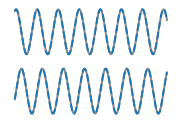

In [6]:
plt.figure(figsize=(3,2))
plt.subplot(2,1,1)
plt.plot(test_set_results['z'][:,0], 'k', color='#888888', linewidth=2)
plt.plot(z_sim[:,0], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

plt.subplot(2,1,2)
plt.plot(test_set_results['z'][:,1], color='#888888', linewidth=2)
plt.plot(z_sim[:,1], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

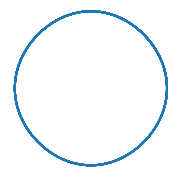

In [7]:
plt.figure(figsize=(3,3))
plt.plot(z_sim[:,0], z_sim[:,1], linewidth=2)
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.savefig('rd_xy.pdf')

In [8]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.016083
Decoder relative SINDy error: 0.016053
SINDy reltive error, z: 0.002793


# Load Bayesian SINDy Coefficients

In [39]:
arr = np.load("save_rd.npy")
arr_truncate = arr[0:-10]
arr_truncate[-1]

array([[ 1.33751222e-04, -9.28087393e-05],
       [-2.45514966e-05, -5.45453513e-05],
       [-1.67042963e-04, -1.27815554e-04],
       [ 2.25311014e-05, -2.20072645e-04],
       [-1.04002291e-04,  7.72989733e-05],
       [ 9.83033897e-05,  5.90038762e-05],
       [ 3.93207665e-06,  1.00026675e-01],
       [ 4.56217640e-06,  1.90563878e-06],
       [-3.79990670e-05,  1.94887889e-07],
       [-2.96421058e-05,  2.39015189e-05],
       [ 9.87167732e-05,  9.06805813e-01],
       [-9.03556168e-01,  5.48957250e-05]])

In [40]:
arr_mean = np.mean(arr_truncate, axis=0)
arr_std = np.std(arr_truncate, axis=0)

In [41]:
arr_mean

array([[ 1.07444957e-07,  9.58492510e-07],
       [ 1.29353418e-05,  1.21824136e-05],
       [ 4.22831632e-06, -2.04970711e-07],
       [ 1.11690153e-05,  2.99559564e-06],
       [-6.87196123e-06,  3.82259313e-07],
       [ 8.97260783e-06,  8.98093960e-06],
       [-5.00342151e-08,  1.04010346e-01],
       [-6.87438146e-07,  1.14142533e-05],
       [ 1.59489542e-06,  6.21885650e-07],
       [-1.35755166e-06,  2.37798498e-06],
       [ 3.42531133e-06,  9.08429258e-01],
       [-9.07067822e-01,  1.44416848e-06]])

In [42]:
arr_mean + 2*arr_std

array([[ 1.52661726e-04,  2.20920458e-04],
       [ 2.21497358e-04,  1.02672074e-04],
       [ 2.66572788e-04,  1.42825259e-04],
       [ 1.69310874e-04,  3.21283393e-04],
       [ 2.51078425e-04,  1.26748068e-04],
       [ 2.41188623e-04,  1.66994001e-04],
       [ 5.77340251e-06,  1.08434668e-01],
       [ 2.48447878e-05,  3.20504068e-05],
       [ 7.85821373e-05,  1.50992895e-05],
       [ 2.63618971e-05,  3.27231639e-05],
       [ 2.79650591e-04,  9.13859886e-01],
       [-8.99354694e-01,  1.66071130e-04]])

In [43]:
arr_mean - 2*arr_std

array([[-1.52446836e-04, -2.19003473e-04],
       [-1.95626674e-04, -7.83072472e-05],
       [-2.58116155e-04, -1.43235200e-04],
       [-1.46972844e-04, -3.15292202e-04],
       [-2.64822347e-04, -1.25983550e-04],
       [-2.23243408e-04, -1.49032121e-04],
       [-5.87347094e-06,  9.95860237e-02],
       [-2.62196641e-05, -9.22190025e-06],
       [-7.53923465e-05, -1.38555182e-05],
       [-2.90770004e-05, -2.79671940e-05],
       [-2.72799968e-04,  9.02998629e-01],
       [-9.14780950e-01, -1.63182793e-04]])

In [27]:
arr = np.load("save_rd_refinement.npy")
arr_truncate = arr[0:-10]
arr_mean = np.mean(arr_truncate, axis=0)
arr_std = np.std(arr_truncate, axis=0)
arr_mean

array([[-1.03767596e-04,  2.32635597e-03],
       [ 2.61343502e-04, -1.44627842e-03],
       [-6.01151520e-04, -3.10470383e-04],
       [-4.52522168e-04,  5.66276941e-04],
       [ 2.31665262e-04,  2.83914785e-04],
       [-2.85146690e-03,  7.80268090e-04],
       [ 1.99337011e-03,  1.04061825e-01],
       [-1.91921347e-03,  1.16249389e-04],
       [ 1.47645606e-03,  5.92584029e-04],
       [-8.67462471e-04, -1.90141891e-04],
       [ 1.50978497e-03,  9.08698210e-01],
       [-9.07024739e-01, -1.28569240e-04]])

In [28]:
arr_mean + 2*arr_std

array([[ 0.0019793 ,  0.04862723],
       [ 0.00521756,  0.02756579],
       [ 0.01142659,  0.00585585],
       [ 0.00879641,  0.01178913],
       [ 0.0049744 ,  0.00592358],
       [ 0.05406123,  0.0161187 ],
       [ 0.04166177,  0.10876396],
       [ 0.03625891,  0.00220388],
       [ 0.03083198,  0.01237422],
       [ 0.01636625,  0.00363871],
       [ 0.03146043,  0.91650218],
       [-0.89942999,  0.00247576]])

In [29]:
arr_mean - 2*arr_std

array([[-0.00218684, -0.04397452],
       [-0.00469487, -0.03045835],
       [-0.0126289 , -0.00647679],
       [-0.00970145, -0.01065658],
       [-0.00451106, -0.00535575],
       [-0.05976417, -0.01455816],
       [-0.03767503,  0.09935969],
       [-0.04009733, -0.00197138],
       [-0.02787907, -0.01118905],
       [-0.01810118, -0.004019  ],
       [-0.02844086,  0.90089424],
       [-0.91461949, -0.00273289]])

In [59]:
arr_truncate += np.random.normal(0, 0.05, size=(100,12, 2))

i, n: 0 0
-0.015591403611280245 0.09406537620716202
i, n: 1 0
0.931923805714898 0.10519437201980837
i, n: 2 0
-0.007204683739787439 0.10145256008273382
i, n: 3 0
0.0019238985395628777 0.11087347454895974
i, n: 4 0
0.0016004174644002618 0.1146881157126281
i, n: 5 0
0.10358205574325668 0.12362958772298333
i, n: 6 0
-0.0038376873087805864 0.10986953791919687
i, n: 7 0
0.01269691625248859 0.1218684128790593
i, n: 8 0
0.00013599588079497862 0.11174542890058937
i, n: 9 0
-0.0019937711818959845 0.1003861843559005
i, n: 10 0
-0.00394598419839953 0.11183149820291592
i, n: 11 0
-0.011979984823324588 0.10197521591044818
i, n: 0 1
-0.8956494225752814 0.12192159276946807
i, n: 1 1
0.0019447326547435446 0.10213955037624584
i, n: 2 1
0.0018989295070152674 0.11763892248993336
i, n: 3 1
0.004688783579745931 0.11275231932668107
i, n: 4 1
0.004267236466799002 0.12005183189560988
i, n: 5 1
-0.008722528798241364 0.10211113094271963
i, n: 6 1
0.011987995350497459 0.10767028683431498
i, n: 7 1
-0.01491513038

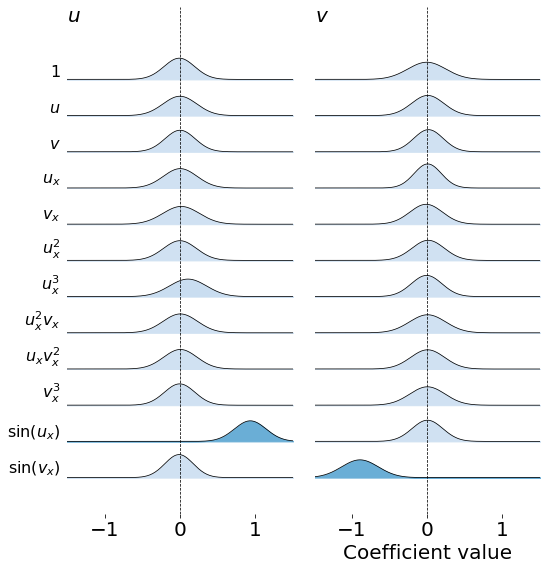

In [60]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

library_names = [r"$1$", r"$u$", r"$v$", r"$u_x$", r"$v_x$", r"$u_x^2$",
                r"$u_x^3$",r"$u_x^2v_x$",r"$u_xv_x^2$",r"$v_x^3$",r"$\sin(u_x)$",r"$\sin(v_x)$",]
library_names.reverse()
latent_dim_names = [r"$u$", r"$v$"]
def curve(arr):
    n = 1
    center = np.mean(arr)
    scale = np.std(arr)
    print(center, scale)
    scale *= 2.0
    X = np.zeros(500)
    x = np.linspace(-3, 3, len(X))
    X = 1.0/(scale*np.sqrt(2*np.pi)) * np.exp(-0.5 * ((x - center) / scale)**2)
    return X/10.0

cmap = mpl.cm.get_cmap("Blues")
fig = plt.figure(figsize=(8, 8))
arr_truncate = arr_truncate.reshape((100, 12, 2))

ax = None
for n in range(2):
    ax = plt.subplot(1, 2, n+1, frameon=False, sharex=ax)
    for i in range(0, len(arr_mean)):
        print("i, n:", i, n)
        Y = curve(arr_truncate[:,11-i, 1-n])
        X = np.linspace(-3, 3, len(Y))
        ax.plot(X, 3 * Y + i, color="k", linewidth=0.75, zorder=100 - i)
        color = cmap(abs(arr_mean[11-i, 1-n]) / 3.0 + 0.2)
        ax.fill_between(X, 3 * Y + i, i, color=color, zorder=100 - i)

    ax.yaxis.set_tick_params(tick1On=False)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1, 13)
    ax.axvline(0.0, ls="--", lw=0.75, color="black", zorder=250)
    ax.text(
        0.0,
        1.0,
        latent_dim_names[n],
        ha="left",
        va="top",
        weight="bold",
        transform=ax.transAxes,
    )

    if n == 0:
        ax.yaxis.set_tick_params(labelleft=True)
        ax.set_yticks(np.arange(len(arr_mean)))
#         ax.set_yticklabels(["Serie %d" % i for i in range(1, len(arr_mean)+1)])
        ax.set_yticklabels(library_names)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(16)
            tick.label.set_verticalalignment("bottom")
    else:
        ax.yaxis.set_tick_params(labelleft=False)

plt.rcParams.update({'font.size': 20})
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# plt.colorbar(fig, cax=cax)
plt.tight_layout()
plt.xlabel('Coefficient value')
plt.show()

In [61]:
z_sim = sindy_simulate(test_set_results['z'][0], test_data['t'][:,0],
                       params['coefficient_mask']*test_set_results['sindy_coefficients'],
                       params['poly_order'], params['include_sine'])

In [62]:
z_sim = np.zeros((1000, 2))
mc_num = 10
mc_z_sim = np.zeros((mc_num, 1000, 2))
for j in range(mc_num):
    coeff = arr_truncate[j*8].reshape(12, 2)
    mc_z_sim[j] = sindy_simulate(test_set_results['z'][0], test_data['t'][:,0],
                   params['coefficient_mask']*coeff,
                   params['poly_order'], params['include_sine'])

In [63]:
mc_z_sim[0]

array([[ 0.7735244 , -0.30299231],
       [ 0.78492578, -0.26942676],
       [ 0.79501349, -0.23549801],
       ...,
       [-0.16489413,  0.88413215],
       [-0.1960175 ,  0.87555983],
       [-0.22690019,  0.86553512]])

In [64]:
mc_z_sim[1]

array([[ 0.7735244 , -0.30299231],
       [ 0.78600619, -0.27185248],
       [ 0.79715941, -0.24034265],
       ...,
       [-0.49643633,  0.66054083],
       [-0.52307428,  0.6389301 ],
       [-0.54893043,  0.61631225]])

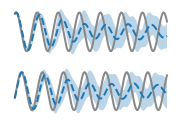

In [65]:
t = np.arange(0, 1000, 1.0)
plt.figure(figsize=(3,2))
plt.subplot(2,1,1)
plt.plot(test_set_results['z'][:,0], 'k', color='#888888', linewidth=2)
plt.plot(t, np.mean(mc_z_sim[:,:,0], axis=0), '--', linewidth=2)
plt.fill_between(t, np.mean(mc_z_sim[:,:,0], axis=0)-1*np.std(mc_z_sim[:,:,0], axis=0),
                np.mean(mc_z_sim[:,:,0], axis=0)+1*np.std(mc_z_sim[:,:,0], axis=0), alpha=0.3)
plt.xticks([])
plt.yticks([])
plt.axis('off')

plt.subplot(2,1,2)
plt.plot(test_set_results['z'][:,1], color='#888888', linewidth=2)
plt.plot(t, np.mean(mc_z_sim[:,:,1], axis=0), '--', linewidth=2)
plt.fill_between(t, np.mean(mc_z_sim[:,:,1], axis=0)-1*np.std(mc_z_sim[:,:,1], axis=0),
                np.mean(mc_z_sim[:,:,1], axis=0)+1*np.std(mc_z_sim[:,:,1], axis=0), alpha=0.3)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.savefig('rd_uq.pdf')

In [25]:
np.std(mc_z_sim[:,:,1], axis=0)

array([0.        , 0.0023184 , 0.00466336, 0.00702832, 0.00940671,
       0.01179197, 0.01417751, 0.01655675, 0.01892306, 0.02126979,
       0.02359019, 0.02587749, 0.02812479, 0.0303251 , 0.03247134,
       0.0345563 , 0.03657267, 0.03851305, 0.04036997, 0.0421359 ,
       0.04380331, 0.0453647 , 0.04681266, 0.04813995, 0.04933954,
       0.05040472, 0.05132917, 0.05210709, 0.05273327, 0.05320325,
       0.0535134 , 0.05366107, 0.05364478, 0.05346432, 0.05312101,
       0.05261785, 0.0519598 , 0.05115404, 0.05021035, 0.04914148,
       0.04796364, 0.04669707, 0.04536668, 0.04400275, 0.04264163,
       0.04132634, 0.0401068 , 0.03903933, 0.03818517, 0.0376074 ,
       0.03736622, 0.03751316, 0.03808524, 0.03910082, 0.04055843,
       0.04243879, 0.04470915, 0.04732844, 0.05025189, 0.05343454,
       0.05683344, 0.06040886, 0.0641247 , 0.06794853, 0.07185133,
       0.07580722, 0.07979309, 0.08378831, 0.08777438, 0.09173473,
       0.09565449, 0.09952026, 0.10331995, 0.10704264, 0.11067

(-49.95, 1048.95, -0.9297636151313782, 0.9319799542427063)

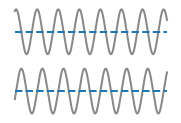

In [27]:
plt.figure(figsize=(3,2))
plt.subplot(2,1,1)
plt.plot(test_set_results['z'][:,0], 'k', color='#888888', linewidth=2)
plt.plot(z_sim[:,0], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

plt.subplot(2,1,2)
plt.plot(test_set_results['z'][:,1], color='#888888', linewidth=2)
plt.plot(z_sim[:,1], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

([], [])

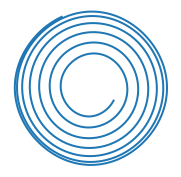

In [26]:
plt.figure(figsize=(3,3))
plt.plot(np.mean(mc_z_sim[:,:,0], axis=0), np.mean(mc_z_sim[:,:,1], axis=0), linewidth=2)
# plt.fill_between(np.mean(mc_z_sim[:,:,0], axis=0)-np.std(mc_z_sim[:,:,0], axis=0),
#                 np.mean(mc_z_sim[:,:,0], axis=0)+np.std(mc_z_sim[:,:,0], axis=0), alpha=0.3)
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

In [106]:
z_sim.shape

(1000, 2)

In [28]:
z_sim = sindy_simulate(test_set_results['z'][0], test_data['t'][:,0],
                       params['coefficient_mask']*np.mean(arr_truncate, axis=0),
                       params['poly_order'], params['include_sine'])

([], [])

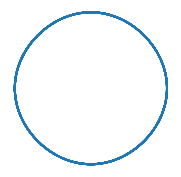

In [29]:
plt.figure(figsize=(3,3))
plt.plot(z_sim[:,0], z_sim[:,1], linewidth=2)
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

In [27]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.015943
Decoder relative SINDy error: 0.016534
SINDy reltive error, z: 0.009469
